In [1]:
# -*- coding:utf-8 -*-
import json
import requests
import csv,re,os,math,glob
from lxml import etree
from datetime import date,datetime
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import hashlib #check md5sum of rawdata files
####新项目，近5年分红去高去低*回购率排名，同时要求分红逆序数（假）不能超过6

In [2]:
#Save_interest_rate

In [3]:
def save_interest_rate(data):
    
    # 1. 创建文件对象
    f = open('CB_interest_rate.csv', 'w', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])
    
    count = 0
    for item in data:
        count +=1
        if (count %10 == 0):
            print("processing "+str(count)+" items")
        try:
            interest = get_interest_rate(item['id'])
            interest = [item['id']]+interest
            csv_writer.writerow(interest)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.")
            print("The error happed at "+item['id'])
    # 5. 关闭文件
    print("Finished processing "+str(count)+" items")
    f.close()


In [4]:
#append_interest_rate

In [5]:
def append_interest_rate(item):
    
    # 1. 创建文件对象
    interest_dict = get_interest_dict('CB_interest_rate.csv')
    if item['id'] in interest_dict:
        return
    f = open('CB_interest_rate.csv', 'a', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    
    

    try:
        interest = get_interest_rate(item['id'])
        interest = [item['id']]+interest
        csv_writer.writerow(interest)
        print("Finished appending new CB "+ item['name']+" into interest rate files")
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print("The error happed at "+item['id'])
    
    # 5. 关闭文件
    
    f.close()


In [6]:
#get_interest_rate

In [7]:
def get_interest_rate(id):
    years = 6
    detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
    detials_response = requests.get(detials_url)
    html = detials_response.content.decode("utf-8")
    html = etree.HTML(html)
    interest_text = html.xpath('.//td[@id="cpn_desc"]/text()')
    if(not interest_text[0].find('%')):
        print(" not in interest test %s %s"%(id,interest_text))
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
    else:
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?\s?%')  #get proper format number
    interest = pattern.findall(interest_text[0])
    if(len(interest) <= 1):
        print("%s fixed interest rate %s"%(id, interest_text[0]))
        interest = interest*years
    elif(len(interest)<5):
        print("%s number of interest rate between 2-4 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    elif(len(interest)>6):
        print("%s number of interest rate greater than 6 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    interest = [rate.strip("%") for rate in interest]
    return interest

In [8]:
# get interest dict

In [9]:
def get_interest_dict(file):
    interest_dict = dict()
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                #skip header
                line_count += 1
            else:
                interest_dict[row[0]] = row[1:]
                line_count += 1
        print(f'Processed {line_count} lines.')
    return interest_dict


In [10]:
# buy or sell cb

In [11]:
def buy_sell_db(db_df,file,show_price=False):
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    total_number = len(db_df)
    quartile = np.percentile(db_df['db_low'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,_,_ = row
            if cb_id not in db_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                continue
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low}
            my_list.append(item)
            if cb_id not in keep_dict.keys():
                sell = "Sell"
                if(db_low>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,db_low))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        db_low = db_df.loc[cb_id]['db_low']
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id in buy_dict.keys():
        if cb_id not in holding_dict.keys():
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            cb_name = keep_dict[cb_id]
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('db_low',ascending=True)
    return my_df,buy_dict
    

In [12]:
#buy sell low

In [13]:
def buy_sell_low(lp_df,db_buy_dict,file,show_price=False):
    total_number = len(lp_df)
    quartile = np.percentile(lp_df['lower_deviation'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:lp_df['name'][i] for i in lp_df[0:keep_number].index}
    buy_dict = {i:lp_df['name'][i] for i in lp_df[0:buy_number].index}
    add_dict = {i:lp_df['name'][i] for i in lp_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,_,_ = row
            if cb_id not in lp_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = lp_df.loc[cb_id]['price']
            db_low  = lp_df.loc[cb_id]['db_low']
            premium = lp_df.loc[cb_id]['premium']
            lower_deviation = lp_df.loc[cb_id]['lower_deviation']
            fit_price = lp_df.loc[cb_id]['fit_price']
            low_fit_price = lp_df.loc[cb_id]['low_fit_price']
            upper_fit_price = lp_df.loc[cb_id]['upper_fit_price']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low,'premium':premium,
                    'lower_deviation':lower_deviation}
            my_list.append(item)
            if cb_id not in keep_dict.keys() or price>fit_price:
                sell = "Sell"
                if(lower_deviation>quartile or price>upper_fit_price):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f"
                          %(sell,cb_id,cb_name,price,db_low,premium,lower_deviation))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if price>=low_fit_price:
            continue
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if cb_id in db_buy_dict.keys():
            print("Strong Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        elif cb_id not in holding_dict.keys():
            if price>=low_fit_price:
                continue
            
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [14]:
# read historical data

In [15]:
def read_historical_data(file):
    history_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            history_list.append(row)
    return history_list

In [16]:
# get data

In [17]:
def get_dat():
    # Fill in your details here to be posted to the login form.
    payload = {
        'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
        'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
        #"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
        "Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
    }
    loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
    r = requests.post(loginUrl,data=payload)

    newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
    #最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
    response = requests.get(newUrl,cookies=r.cookies)
    data = response.content.decode("utf-8")
    dat = json.loads(data)

    # 所有数据
    lst_data = []
    raw_data = []
    count = 0
    
    for one in dat['rows']:
        # 每一条数据
        lst_dat = dict()
        # 转债id
        id = one["id"]
        dat_cell = one["cell"]
        # 是否赎回
        is_force_redeem = dat_cell['redeem_flag']
        is_list = dat_cell['price_tips']
        raw_data.append(dat_cell)
        if is_list != "待上市":
            
            count += 1
            if (count %100 == 0):
                print("processing "+str(count)+" items")
            
            # 现价
            price = dat_cell['price']
            # stock id
            stock_id = dat_cell['stock_id']
            stock_id = stock_id.replace("sh", "ss")
            stock_id = stock_id[2:]+"."+stock_id[0:2]
            # stock name
            stock_nm = dat_cell['stock_nm']
            # 溢价率
            premium_rt = dat_cell['premium_rt']
            # 评级
            rating_cd = dat_cell['rating_cd']
            
            
            # next put date
            next_put_dt = dat_cell['next_put_dt']
            # put price
            put_price   = dat_cell['put_price']
            # 回售触发价
            put_convert_price = dat_cell['put_convert_price']
            
            
            # maturity date
            maturity_dt = dat_cell['maturity_dt']
            # redeem price
            redeem_price = dat_cell['redeem_price']
            
            # 强赎触发价
            redeem_dt = dat_cell['redeem_dt']
            force_redeem_price = dat_cell['force_redeem_price']
            # 剩余时间
            last_time = dat_cell['year_left']
            #pb
            pb = dat_cell['pb']


            #lst_dat.append(id)
            lst_dat['id'] = id
            lst_dat['name'] = dat_cell['bond_nm'] # 转债名称
            lst_dat['stock_id'] = stock_id
            lst_dat['stock_name'] = stock_nm
            lst_dat['price'] = float(price)
            lst_dat['convert_value'] = float(dat_cell['convert_value'])
            lst_dat['premium_rt'] = premium_rt
            lst_dat['rating_cd'] = rating_cd
            lst_dat['pb']  = pb
            lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
            lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']
            
            
            
            lst_dat['next_put_dt'] = next_put_dt
            lst_dat['put_price'] = put_price
            lst_dat['put_convert_price'] = put_convert_price
            
            lst_dat['maturity_dt'] = maturity_dt
            lst_dat['redeem_price'] = redeem_price
            lst_dat['last_time'] = last_time
            lst_dat['force_redeem'] = is_force_redeem
            
            lst_dat['redeem_dt']  = redeem_dt
            lst_dat['force_redeem_price'] = force_redeem_price
            
            lst_dat['redeem_price_ratio']  =  dat_cell['redeem_price_ratio']
            lst_dat['redeem_count_days'] =  dat_cell['redeem_count_days']
            lst_dat['redeem_real_days']  =  dat_cell['redeem_real_days']
            
            
            
  
            lst_data.append(lst_dat)
           
            
        else:
            continue
    print("Finished processing "+str(count)+" items")
    
    return lst_data,raw_data

In [18]:
#put arbitrage

In [19]:
def put_arbitrage(data):
    data_copy = deepcopy(data)
    put_data = []
    count = 0
    for item in data_copy:
        price       = item['price']
        put_price   = item['put_price']

        
        if(put_price is None):
            continue
            
        price = float(price)
        put_price = float(put_price)
            
        if(price>put_price+5.0): ###To Save Time, the maximun interest could not over 10
            continue
            
        next_put_dt = item['next_put_dt']
        next_put_dt = datetime.strptime(next_put_dt,'%Y-%m-%d').date()
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        days_to_put  = next_put_dt-today
        years_to_put  = days_to_put.days/365
        
        put_to_maturity = round(years_to_maturity-years_to_put)
        #print(put_to_maturity)
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
        
        
        total_interest = 0
        for i in range(3,math.ceil(years_to_put)+put_to_maturity+1):
            #print(i)
            #print(interest)
            #print(item['id'])
            total_interest += float(interest[-i])
        
        
    
        
        actual_put_price = put_price*(1+total_interest*0.008)  ####20%的所得税
        
        
        if(price<actual_put_price):
            year_diff = years_to_put + 38/365  #进入回售期后的38日
            profit_rate = actual_put_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['actual_put_price'] = actual_put_price
            item['CAGR'] = CAGR
            item['last_to_put'] = year_diff
            put_data.append(item)
        
        count += 1
        if (count %100 == 0):
            print("processing"+str(count)+" items")
    
    print("Finished processing "+str(count)+" items")
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [20]:
# redeem arbitrage

In [21]:
def redeem_arbitrage(data):
    put_data = []
    data_copy = deepcopy(data)
    for item in data_copy:
        price       = item['price']
        redeem_price   = item['redeem_price']

        
        if(redeem_price is None):
            continue
            
        price = float(price)
        redeem_price = float(redeem_price)
            

        
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
            
        total_interest = 0
        for i in range(2,math.ceil(years_to_maturity)):
            total_interest += float(interest[-i])
            
        actual_price = redeem_price*(1+total_interest*0.008)
        
        if(price<actual_price):
            year_diff = years_to_maturity
            profit_rate = actual_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['CAGR'] = CAGR
            put_data.append(item)
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [22]:
# double low arbitarge

In [23]:
def double_low_arbitrage(data,redeem_df,put_df):
    db_data = []
    DISCOUNT = 1  ###convert amt ratio discount 
    data_copy = deepcopy(data)
    
    redeem_dict = redeem_df.to_dict('index')
    put_dict = put_df.to_dict('index')
    
    stock_amt_ratio_dict = dict()
    for item in data_copy:
        id = item['id']
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            continue
        stock_id = item['stock_id']
        convert_amt_ratio = item['convert_amt_ratio2'] #####ratio is float ratio, ratio is total ratio
        convert_value = float(item['convert_value'])
        
        convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        #####Adjust convert amt ratio
        convert_amt_ratio *= convert_value/100  ###adjust the convert amt ratio to the percentage shares
        
        if stock_id not in stock_amt_ratio_dict.keys():
            stock_amt_ratio_dict[stock_id] = convert_amt_ratio
        else:
            stock_amt_ratio_dict[stock_id] += convert_amt_ratio
        
    
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        price       = item['price']
        premium_rt = item['premium_rt']
        convert_value = float(item['convert_value'])
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            convert_amt_ratio = item['convert_amt_ratio2']#####ratio is float ratio, ratio is total ratio
            convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
            #####Adjust convert amt ratio
            convert_amt_ratio *= convert_value/100  ###adjust the convert amt ratio to the percentage shares
   
            
        else:
            convert_amt_ratio = stock_amt_ratio_dict[stock_id]
        
        price = float(price)
        premium_rt = float(premium_rt.strip('%'))/100
        #convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        
    
 
        convert_value_discount = 1/(1+convert_amt_ratio*DISCOUNT)
        new_convert_value = convert_value*convert_value_discount
        new_premium = price/new_convert_value - 1
        #new_premium = new_premium*math.sqrt(price/100) if price>100 else new_premium
 
        
        redeem_cagr = 0
        put_cagr = 0
        if(id in redeem_dict.keys()):
            redeem_cagr = redeem_dict[id]['CAGR']
        if(id in put_dict.keys()):
            put_cagr = put_dict[id]['CAGR']
        
        item['redeem_CAGR'] = redeem_cagr
        item['put_CAGR']    = put_cagr
        item['new_convert_value'] = new_convert_value
        item['new_premium'] = new_premium
        if(redeem_cagr>put_cagr):
            db_low = price + new_premium*100 - redeem_cagr*100
        else:
            db_low = price + new_premium*100 - put_cagr*100
        
        #item['db_low'] = db_low*math.sqrt(price/100) if price>100 else db_low
        item['db_low'] = db_low
        
        db_data.append(item)
    df = pd.DataFrame(db_data)
    df = df.set_index(['id'])
    df = df.sort_values('db_low')
    return df

In [24]:
# low premium arbitrage

In [25]:
def low_premium_arbitrage(db_df): 
    import scipy.stats as stats
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    x = []
    y = []
    ids = []
    names = []
    db_lows = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        price = db_df['price'][cb_id]
        db_low = db_df['db_low'][cb_id]
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        x.append(value)
        y.append(price)
        ids.append(cb_id)
        names.append(name)
        db_lows.append(db_low)

    x = np.array(x)
    y = np.array(y)
    ids = np.array(ids)
    names = np.array(names)
    db_lows = np.array(db_lows)
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    ids = ids[indexes]
    names = names[indexes]
    db_lows = db_lows[indexes]

    coef = np.polyfit(x, y, 2)
    save_coef_data(coef,'coef_history.csv')
    poly = np.poly1d(coef)

    n = len(x)
    yfit = poly(x)
    resid = y - yfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    convert_value_limit = (1-coef[1])/2/coef[0]
    price_limit = poly(convert_value_limit)
    #xext = np.linspace(convert_value_limit,max(x))
    #yext = xext+price_limit-convert_value_limit
    ext_index = np.argmax(x>=convert_value_limit)
    xext = x[ext_index:]
    yext = xext+price_limit-convert_value_limit
    piext = pi[ext_index:]

    lp_data = []
    for i,cb_id in enumerate(ids):
        value = x[i]
        price = y[i]
        cb_name = names[i]
        db_low  = db_lows[i]

        premium = (price/value-1)*100
        
        if(price<price_limit):
            lower_deviation = price/(yfit[i]-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':yfit[i],'low_fit_price':yfit[i]-pi[i],
                    'upper_fit_price':yfit[i]+pi[i]}
        else:
            intercept = price_limit - convert_value_limit
            lower_deviation = price/(x[i]+intercept-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':x[i]+intercept,'low_fit_price':x[i]+intercept-pi[i],
                    'upper_fit_price':x[i]+intercept+pi[i]}
        lp_data.append(item)
        plt.rcParams["figure.figsize"] = (18,10)
        if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
            plt.scatter(value, price, marker='o', s=5,color='maroon')
            plt.text(value+.03, price+.03, cb_id, fontsize=8)
        else:
            plt.scatter(value, price, marker='o', s=5,color='darkgreen')
            



    lp_df = pd.DataFrame(lp_data)
    lp_df = lp_df.set_index(['id'])
    lp_df = lp_df.sort_values('lower_deviation')
    plt.plot(x,yfit,color='red')
    plt.plot(xext,yext,color='skyblue')
    plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    plt.fill_between(xext, yext-piext, yext,color='skyblue',alpha=0.1)
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    return lp_df

In [26]:
# save historical data

In [27]:
def save_historical_data(df,col,file):
    s = df[col]
    min_db = s.min()
    max_db = s.max()
    mean_db = s.mean()
    median_db = s.median()
    pt2_db = np.percentile(s,2)
    pt5_db = np.percentile(s,5)
    pt10_db = np.percentile(s,10)
    quartile_db = np.percentile(s,25)
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        #csv_writer.writerow(["date","min", "quartile", "median", "mean", "max"])
        today_item = [today,str(min_db),str(pt2_db),str(pt5_db),str(pt10_db),str(quartile_db),str(median_db),str(mean_db),str(max_db)]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","min", "pt2","pt5","pt10","quartile", "median", "mean", "max"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,min_db,pt2_db,pt5_db,pt10_db,quartile_db,median_db,mean_db,max_db])
        f.close()
    
    print('today quartile '+str(quartile_db))
    
    

In [28]:
#save coeffient 

In [29]:
def save_coef_data(coef,file):
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        today_item = [today,str(coef[0]),str(coef[1]),str(coef[2])]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","a", "b","c"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,coef[0],coef[1],coef[2]])
        f.close()
    
    print('today coef '+str(coef))
    

In [30]:
# save raw data

In [31]:
def save_raw_data():
    import warnings
    files = glob.glob("raw_data/CB_list*csv")
    files = np.array(sorted(files))
    md5_old = hashlib.md5(open(files[-1],'rb').read()).hexdigest()
    md5_new = hashlib.md5(open('CB_list.csv','rb').read()).hexdigest()
    if(md5_old != md5_new):
        today = date.today().strftime("%Y-%m-%d")
        new_file = 'raw_data/CB_list.'+today+'.csv'
        return_value = os.system("cp CB_list.csv "+new_file)
        if return_value == 0:
            print("successfully save raw CB data")
        else:
            warnings.warn("problems when copying CB_list files")
    else:
        print("No need to update raw CB list")

In [32]:
# plot history

In [33]:
def plot_history(file):
    import datetime as dt
    import matplotlib.dates as mdates
    his = pd.read_csv(file, sep=',')
    his['date'] = pd.to_datetime(his['date'], format='%Y-%m-%d')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

    plt.plot( 'date', 'min', data=his, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'date', 'pt2', data=his, marker='o', markerfacecolor='sienna', markersize=6, color='peru', linewidth=2)
    plt.plot( 'date', 'pt5', data=his, marker='o', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    plt.plot( 'date', 'pt10', data=his, marker='o', markerfacecolor='gold', markersize=6, color='goldenrod', linewidth=2)
    plt.plot( 'date', 'quartile', data=his, marker='o', markerfacecolor='olivedrab', markersize=6, color='olive', linewidth=2)
    plt.plot( 'date', 'median', data=his, marker='o', markerfacecolor='darkorange', markersize=6, color='orange', linewidth=2)
    #plt.plot( 'date', 'mean', data=his, marker='v', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    # show legend
    plt.gcf().autofmt_xdate()
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    # show graph
    plt.show()

In [34]:
data,raw_data = get_dat()
pd.DataFrame.from_dict(raw_data).to_csv(r'CB_list.csv',index=False)
save_raw_data()

processing 100 items
processing 200 items
processing 300 items
Finished processing 383 items
successfully save raw CB data


In [35]:
interest_dict = get_interest_dict('CB_interest_rate.csv')

Processed 403 lines.


In [36]:
redeem_df = redeem_arbitrage(data)

In [37]:
put_df = put_arbitrage(data)

Finished processing 42 items


Strong Sell 113039 嘉泽转债 163.88 168.298
Strong Sell 113595 花王转债 89.93 219.682
123068 弘信转债 not in lists
Sell 127034 绿茵转债 103.679 151.970

Add  128100 搜特转债 102.85 125.612
Add  113009 广汽转债 118.9 130.844
Add  113607 伟20转债 127.97 132.253
Add  132018 G三峡EB1 130.35 133.201
Add  113577 春秋转债 118.3 135.646
Add  128133 奇正转债 118.403 135.914
Add  110070 凌钢转债 124.5 136.346

Buy  113009 广汽转债 118.9 130.844
Buy  110070 凌钢转债 124.5 136.346
Buy  113030 东风转债 122.43 137.132
Buy  128040 华通转债 112.72 137.931
Buy  128108 蓝帆转债 113.25 138.402
Buy  128037 岩土转债 108.8 139.176
Buy  113565 宏辉转债 109.2 139.443
Buy  113541 荣晟转债 127.27 140.409
Buy  123002 国祯转债 113.228 140.853
Buy  113536 三星转债 121.59 140.977
today coef [ 3.65254034e-03 -9.41090440e-02  9.86966133e+01]
mse=32.516


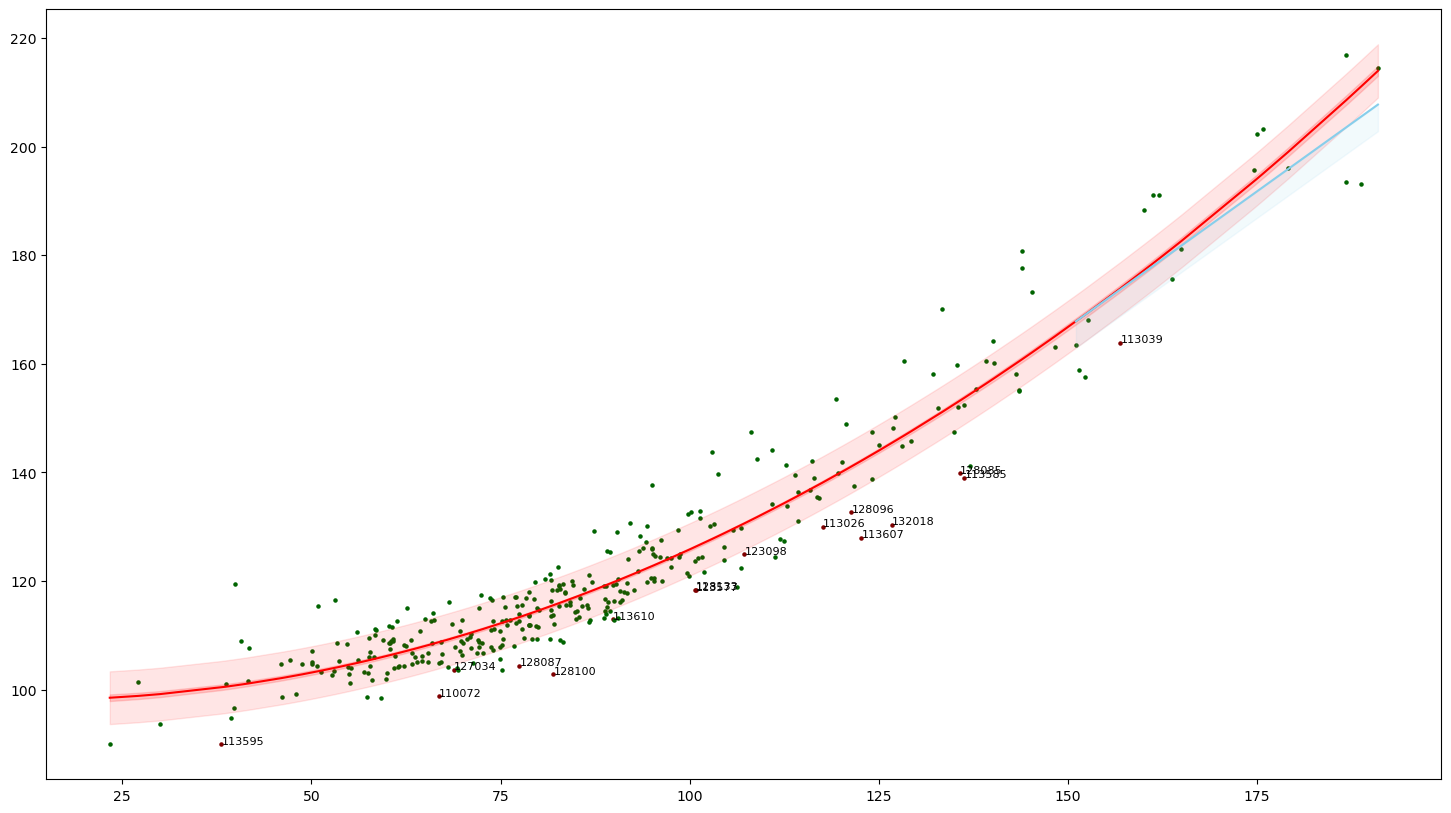

In [38]:
db_df = double_low_arbitrage(data,redeem_df,put_df)
my_df,db_buy_dict = buy_sell_db(db_df,'mycb_list.csv',show_price=True)
lp_df = low_premium_arbitrage(db_df)

In [39]:
lp_df[(lp_df['value'] < 200) & (lp_df['value'] > 180)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
123103,震安转债,188.803239,193.201,2.329283,195.530283,-3.720115,205.565466,200.666007,210.464926
113525,台华转债,186.819142,193.470,3.560052,197.030052,-2.624646,203.581370,198.684772,208.477967
113528,长城转债,190.988148,214.550,12.336814,226.886814,5.769008,207.750375,202.847700,212.653050
123102,华自转债,186.783509,216.918,16.133379,233.051379,9.196519,203.545736,198.649189,208.442283


In [40]:
buy_sell_low(lp_df,db_buy_dict,'mycb_list.csv',show_price=True)

123068 弘信转债 not in lists
Sell 123098 一品转债 124.975 141.537 16.562 -0.629
Sell 127034 绿茵转债 103.679 151.970 50.645 -0.967

Add  132018 G三峡EB1 130.35 133.201 2.851 -7.291
Add  128100 搜特转债 102.85 125.612 25.474 -7.089
Add  113607 伟20转债 127.97 132.253 4.283 -6.806
Add  113585 寿仙转债 139.0 140.994 1.994 -6.628
Add  113595 花王转债 89.93 219.682 136.053 -5.899
Add  128085 鸿达转债 139.876 142.936 3.060 -5.721

Strong Buy 132018 G三峡EB1 130.35 133.201 2.851 -7.291
Strong Buy 128100 搜特转债 102.85 125.612 25.474 -7.089
Strong Buy 113607 伟20转债 127.97 132.253 4.283 -6.806
Buy 132014 18中化EB 141.22 144.236 3.016 -5.597
Strong Buy 113009 广汽转债 118.9 130.844 11.944 -4.940
Buy 123028 清水转债 157.5 160.970 3.470 -4.049
Buy 128062 亚药转债 89.916 367.125 285.336 -3.969
Strong Buy 128087 孚日转债 104.381 137.497 34.739 -3.796
Buy 123103 震安转债 193.201 195.530 2.329 -3.720
Buy 132004 15国盛EB 103.52 141.267 37.747 -3.636
Strong Buy 110070 凌钢转债 124.5 136.346 11.846 -3.225
Buy 123083 朗新转债 158.904 163.795 4.891 -2.759


In [41]:
df2 = lp_df.sort_values('lower_deviation')
df2[0:30]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
132018,G三峡EB1,126.737238,130.350,2.850593,133.200593,-7.290920,145.437792,140.601114,150.274469
128100,搜特转债,81.969418,102.850,25.473624,125.611841,-7.089224,115.523915,110.697601,120.350230
113607,伟20转债,122.714228,127.970,4.282936,132.252936,-6.806445,142.150902,137.316363,146.985442
113585,寿仙转债,136.282788,139.000,1.993804,140.993804,-6.628124,153.709796,148.867096,158.552495
113595,花王转债,38.097407,89.930,136.052812,219.682355,-5.899295,100.412645,95.567828,105.257462
128085,鸿达转债,135.722726,139.876,3.060117,142.936117,-5.720915,153.206075,148.363766,158.048384
132014,18中化EB,137.085189,141.220,3.016234,144.236234,-5.596685,154.435471,149.592204,159.278737
113009,广汽转债,106.213776,118.900,11.944047,130.844047,-4.939563,129.906582,125.078322,134.734841
110072,广汇转债,66.806867,98.800,47.888988,143.821461,-4.891941,108.711346,103.881838,113.540853


In [42]:
my_df

,name,price,db_low
id,,,
128100,搜特转债,102.850,125.611841
113607,伟20转债,127.970,132.252936
132018,G三峡EB1,130.350,133.200593
113577,春秋转债,118.300,135.645503
128133,奇正转债,118.403,135.913885
113610,灵康转债,112.940,137.429525
128087,孚日转债,104.381,137.497064
113026,核能转债,129.970,140.486923
113585,寿仙转债,139.000,140.993804


today quartile 151.96077841365133


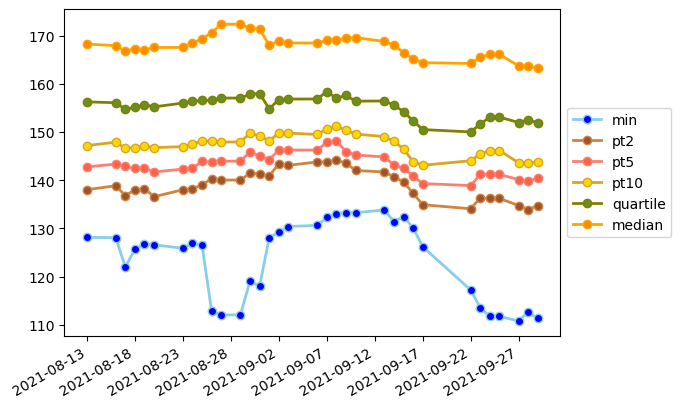

In [43]:
save_historical_data(db_df,'db_low','db_history.csv')
plot_history('db_history.csv')

today quartile 25.699101488866084


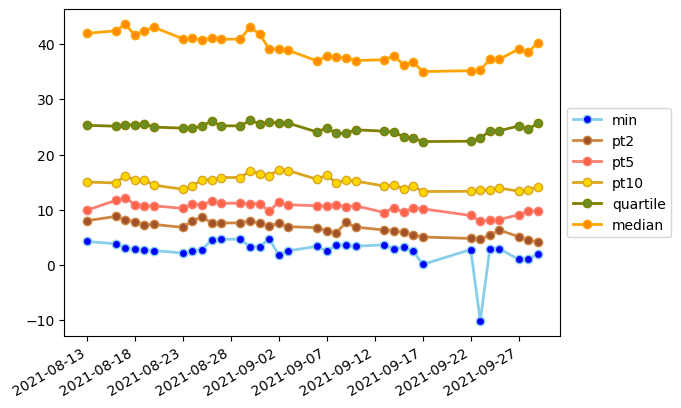

In [44]:
save_historical_data(lp_df,'premium','premium_history.csv')
plot_history('premium_history.csv')

today quartile 109.03999999999999


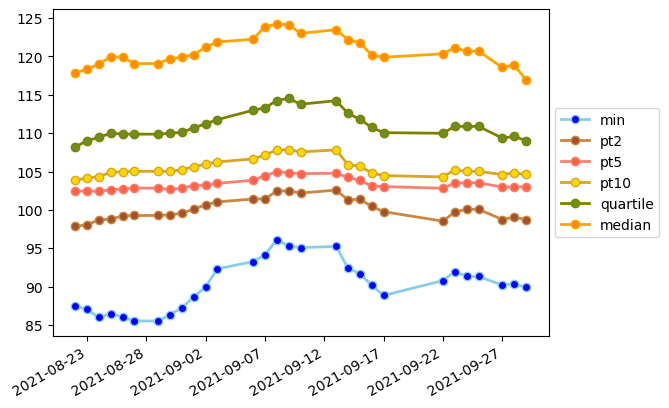

In [45]:
save_historical_data(db_df,'price','price_history.csv')
plot_history('price_history.csv')

In [46]:
db_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,redeem_dt,force_redeem_price,redeem_price_ratio,redeem_count_days,redeem_real_days,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
123051,今天转债,300532.sz,今天国际,105.650,104.83,0.78%,A+,2.94,12.2%,7.4%,...,2021-10-14,11.31,130.000,15,14,0.029604,0.0,97.283324,0.086003,111.289955
128018,时达转债,002527.sz,新时达,106.815,106.66,0.15%,AA,1.77,9.3%,7.3%,...,2021-10-27,9.57,130.000,15,16,0.003160,0.0,98.955172,0.079428,114.441839
123068,弘信转债,300657.sz,弘信电子,108.487,99.48,9.05%,AA-,4.39,3.4%,3.2%,...,2021-10-11,19.94,130.000,15,15,0.020764,0.0,96.410894,0.125257,118.936270
110033,国贸转债,600755.ss,厦门国贸,116.770,116.82,-0.04%,AAA,0.56,3.0%,3.0%,...,None,8.74,130.000,15,15,0.000000,0.0,112.864549,0.034603,120.230299
128100,搜特转债,002503.sz,搜于特,102.850,95.06,8.19%,A,1.95,20.4%,16.8%,...,None,2.11,130.000,15,0,0.027118,0.0,81.969418,0.254736,125.611841
113009,广汽转债,601238.ss,广汽集团,118.900,108.05,10.04%,AAA,1.78,2.4%,1.6%,...,None,18.10,130.000,15,12,0.000000,0.0,106.213776,0.119440,130.844047
113607,伟20转债,603568.ss,伟明环保,127.970,127.73,0.19%,AA,6.04,3.2%,3.2%,...,None,28.22,130.000,20,16,0.000000,0.0,122.714228,0.042829,132.252936
132018,G三峡EB1,600900.ss,长江电力,130.350,132.62,-1.53%,AAA,3.06,3.5%,3.5%,...,None,20.09,120.000,15,11,0.000000,0.0,126.737238,0.028506,133.200593
113577,春秋转债,603890.ss,春秋电子,118.300,104.61,13.09%,AA-,2.58,4.1%,3.6%,...,None,14.11,130.000,15,0,0.000000,0.0,100.813407,0.173455,135.645503


In [47]:
db_df[10:20]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,redeem_dt,force_redeem_price,redeem_price_ratio,redeem_count_days,redeem_real_days,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
110070,凌钢转债,600231.ss,凌钢股份,124.500,114.50,8.73%,AA,0.95,2.5%,2.5%,...,None,3.50,130.000,15,14,0.000000,0.0,111.313647,0.118461,136.346124
120004,20华菱EB,000932.sz,华菱钢铁,133.000,132.11,0.67%,AAA,1.13,2.9%,2.4%,...,2021-10-21,6.40,130.000,15,22,0.000000,0.0,128.049996,0.038657,136.865681
113030,东风转债,601515.ss,东风股份,122.430,110.39,10.91%,AA,2.12,3.1%,3.1%,...,None,8.38,130.000,15,0,0.000000,0.0,106.737352,0.147021,137.132115
113610,灵康转债,603669.ss,灵康药业,112.940,96.52,17.01%,AA-,4.22,7.7%,7.7%,...,None,11.19,130.000,15,0,0.012189,0.0,89.842844,0.257084,137.429525
128087,孚日转债,002083.sz,孚日股份,104.381,89.78,16.26%,AA-,1.00,17.8%,17.7%,...,None,5.85,130.000,15,0,0.016225,0.0,77.469306,0.347385,137.497064
128040,华通转债,002758.sz,浙农股份,112.720,94.09,19.80%,AA,1.50,11.9%,4.8%,...,None,13.20,130.000,15,0,0.000000,0.0,90.024218,0.252108,137.930751
128108,蓝帆转债,002382.sz,蓝帆医疗,113.250,98.03,15.53%,AA,1.39,8.5%,8.5%,...,None,23.71,130.000,15,0,0.000000,0.0,90.489885,0.251521,138.402109
128037,岩土转债,002542.sz,中化岩土,108.800,92.26,17.93%,AA,1.25,14.5%,11.7%,...,None,4.03,130.000,15,0,0.002816,0.0,83.271342,0.306572,139.175645
113565,宏辉转债,603336.ss,宏辉果蔬,109.200,88.48,23.42%,AA-,2.77,7.6%,7.6%,...,None,9.93,130.000,15,0,0.014739,0.0,82.905065,0.317169,139.443025


In [48]:
lp_df[0:20]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
132018,G三峡EB1,126.737238,130.350,2.850593,133.200593,-7.290920,145.437792,140.601114,150.274469
128100,搜特转债,81.969418,102.850,25.473624,125.611841,-7.089224,115.523915,110.697601,120.350230
113607,伟20转债,122.714228,127.970,4.282936,132.252936,-6.806445,142.150902,137.316363,146.985442
113585,寿仙转债,136.282788,139.000,1.993804,140.993804,-6.628124,153.709796,148.867096,158.552495
113595,花王转债,38.097407,89.930,136.052812,219.682355,-5.899295,100.412645,95.567828,105.257462
128085,鸿达转债,135.722726,139.876,3.060117,142.936117,-5.720915,153.206075,148.363766,158.048384
132014,18中化EB,137.085189,141.220,3.016234,144.236234,-5.596685,154.435471,149.592204,159.278737
113009,广汽转债,106.213776,118.900,11.944047,130.844047,-4.939563,129.906582,125.078322,134.734841
110072,广汇转债,66.806867,98.800,47.888988,143.821461,-4.891941,108.711346,103.881838,113.540853


In [49]:
print(np.percentile(db_df['db_low'],50))
print(np.percentile(db_df['price'],50))
print(np.percentile(lp_df['premium'],50))

163.41117187718245
116.96
40.194230078032646


In [50]:
lp_df[(lp_df['value'] < 30) & (lp_df['price']>70)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
128062,亚药转债,23.334425,89.916,285.336250,367.124680,-3.968774,98.489424,93.632044,103.346804
113596,城地转债,29.938015,93.670,212.879794,302.799692,-0.669684,99.152892,94.301523,104.004260
132011,17浙报EB,27.027852,101.420,275.242545,374.894799,7.931156,98.821246,93.967306,103.675186


In [51]:
put_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,last_time,force_redeem,redeem_dt,force_redeem_price,redeem_price_ratio,redeem_count_days,redeem_real_days,actual_put_price,CAGR,last_to_put
id,,,,,,,,,,,,,,,,,,,,,
128062,亚药转债,002370.sz,亚太药业,89.916,25.91,247.03%,BB,3.66,49.4%,42.6%,...,3.510,X,None,21.12,130.000,15,0,102.00,0.081276,1.613699
113595,花王转债,603007.ss,ST花王,89.930,43.50,106.74%,BBB+,0.90,32.9%,32.6%,...,4.808,X,None,9.00,130.000,15,0,102.64,0.046349,2.917808
113576,起步转债,603557.ss,ST起步,94.700,41.42,128.63%,A,1.34,12.3%,12.3%,...,4.529,N,None,13.71,130.000,15,0,103.04,0.032577,2.632877
113596,城地转债,603887.ss,城地香江,93.670,33.22,181.97%,AA-,0.88,42.1%,33.0%,...,4.827,X,None,31.54,130.000,15,0,102.48,0.031079,2.936986
128044,岭南转债,002717.sz,岭南股份,99.140,51.34,93.10%,AA-,1.08,20.4%,13.6%,...,2.877,X,None,7.27,130.000,15,0,101.20,0.021249,0.978082
113589,天创转债,603608.ss,天创时尚,96.590,44.26,118.23%,AA,1.38,25.7%,25.7%,...,4.734,X,None,15.98,130.000,20,0,102.48,0.021053,2.841096
113578,全筑转债,603030.ss,全筑股份,98.640,64.57,52.76%,AA,0.93,21.0%,19.5%,...,4.556,X,None,6.83,130.000,15,0,102.48,0.014460,2.660274
128127,文科转债,002775.sz,文科园林,98.406,81.56,20.65%,AA-,0.90,53.5%,46.5%,...,4.890,X,None,6.34,130.000,15,0,102.64,0.014167,2.994521
127019,国城转债,000688.sz,国城矿业,98.615,47.72,106.65%,AA,4.51,7.4%,7.4%,...,4.792,X,None,27.38,130.000,15,0,102.40,0.013078,2.898630


In [52]:
def func(X, a, b, c, d):
    x,y = X
    return a * x ** 2 + b * x +  c * y + d 
    #return a* x + b*1/x + c*y +d

In [53]:
def three_factor_arbitrage(db_df): 
    import scipy.stats as stats
    from scipy.optimize import curve_fit
    
    redeem_default_prob = 0.5    #####probility of force redeem if conditons is satisfied
    time_decay_factor = 0.25  ######hyper parameter simulated time decay 
    redeem_default_days = 20 ####20 days to be forced redeem
    
    regression_data = []
    for cb_id,row in db_df.iterrows():
        name = row['name']
        price = row['price']
        value = row['new_convert_value']
        premium = row['new_premium']
        db_low = row['db_low']
        force_redeem = row['force_redeem']
        convert_value       = float(row['convert_value'])
        redeem_price_ratio  = float(row['redeem_price_ratio'])
        redeem_count_days   = int(row['redeem_count_days'])
        redeem_real_days    = int(row['redeem_real_days'])
        
        today = date.today()
        time_to_exp = 0
        expire_dt = today
        time_to_redeem = 0
        redeem_prob = 1
        if(force_redeem == 'Y'):
            redeem_dt    = row['redeem_dt']
            expire_dt = redeem_dt     
            if(redeem_dt == None):
                time_to_redeem = redeem_default_days/365 
            else:
                redeem_dt = datetime.strptime(redeem_dt,'%Y-%m-%d').date()
                days_interval = redeem_dt-today
                time_to_redeem = days_interval.days/365
            time_to_exp = time_to_redeem
        else:
            maturity_dt  = row['maturity_dt']
            expire_dt = maturity_dt
            maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
            days_interval = maturity_dt-today
            time_to_exp = days_interval.days/365
            redeem_prob = 0
            if(force_redeem == 'X' and convert_value >= redeem_price_ratio):
                days_to_satisfied = redeem_count_days-redeem_real_days if redeem_count_days>redeem_real_days  else 0
                days_to_satisfied += redeem_default_days
                time_to_redeem = days_to_satisfied/365
                redeem_prob = redeem_default_prob*redeem_real_days/redeem_count_days if redeem_count_days>redeem_real_days else redeem_default_prob
                #print("可能强赎:%s,%s,%s,%s,%d,redeem_prob:%.3f"%(cb_id,name,convert_value,price,redeem_real_days,redeem_prob))
                
        time_value = (1-redeem_prob) * time_to_exp ** time_decay_factor + redeem_prob * time_to_redeem ** time_decay_factor
            
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            #print("妖债:%s,%s,%s,%s"%(cb_id,name,convert_value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        regression_data.append({'id':cb_id,'name':name,'db_low':db_low,'value':value,'price':price,'time':time_to_exp,
                                'expire':expire_dt,'time_value':time_value,'redeem_prob':redeem_prob})

    
    regression_df = pd.DataFrame(regression_data)
    regression_df = regression_df.set_index(['id'])
    #y_df.sort_values('deviation',ascending=True)
    
    x  = regression_df['value']
    y  = regression_df['time_value']
    z = regression_df['price']
    
    popt, pcov = curve_fit(func,(x,y),z)
    print(popt)
    limit_value = (1-popt[1])/2/popt[0]
    intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
    print(limit_value)
    zfit = func((x,y), *popt)

    n = len(x)
    resid = z - zfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)

    td_data = []
    se = 0
    for cb_id,row in regression_df.iterrows():
        cb_name = row['name']
        db_low  = row['db_low']
        value      = row['value']
        time_to_exp = row['time']
        expire_dt  = row['expire']
        time_value = row['time_value']
        price = row['price']
        premium = price/value-1
        fit_price = func((value,time_value), *popt)
        
                     
        origin_time_value = time_to_exp ** time_decay_factor
        origin_fit_price = func((value,origin_time_value), *popt)
        
        if(value>limit_value):
            fit_price = value+intercept + popt[2] * time_value + popt[3]
            origin_fit_price = value+intercept + popt[2] * origin_time_value + popt[3]
         
           ####set minimum fit price
        minimum_fit_price = origin_fit_price/(1+premium)
        if(fit_price < minimum_fit_price):
            fit_price = minimum_fit_price
        
        se += (fit_price-price)**2
        deviation = price/(fit_price)*100-100
        item = {'id':cb_id,'name':cb_name,'value': value,'time_to_exp':time_to_exp,'price':price,
                'premium':premium,'db_low':db_low, 'deviation':deviation,
                'fit_price':fit_price,'ori_fit_price':origin_fit_price,'min_fit_price':minimum_fit_price,'expire_dt':expire_dt,'redeem_prob':row['redeem_prob']}
        td_data.append(item)
            

    td_df = pd.DataFrame(td_data)
    td_df = td_df.set_index(['id'])
    td_df = td_df.sort_values('deviation')
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    mse2 = se/n
    print("adjuse mse=%.3f"%mse2)
    return popt,td_df

In [54]:
def buy_sell_three(td_df,file,show_price=False):
    total_number = len(td_df)
    quartile = np.percentile(td_df['deviation'],25) ##first quartile
    tenthtile = np.percentile(td_df['deviation'],10) ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    buy_dict = {i:td_df['name'][i] for i in td_df[0:buy_number].index}
    add_dict = {i:td_df['name'][i] for i in td_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,position1,position2 = row
            if cb_id not in td_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = td_df.loc[cb_id]['price']
            value = td_df.loc[cb_id]['value']
            time_to_exp  = td_df.loc[cb_id]['time_to_exp']
            premium = td_df.loc[cb_id]['premium']
            deviation = td_df.loc[cb_id]['deviation']
            fit_price = td_df.loc[cb_id]['fit_price']
            expire_dt = td_df.loc[cb_id]['expire_dt']
            redeem_prob = td_df.loc[cb_id]['redeem_prob']
            item = {'id':cb_id,'name':cb_name,'time_to_exp':time_to_exp,'value':value,'price':price,'premium':premium,
                'deviation':deviation,'expire_dt':expire_dt,'redeem_prob':redeem_prob,'position1':position1,'positon2':position2}
            my_list.append(item)
            if deviation > tenthtile:
                sell = "Sell"
                if(deviation>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                          %(sell,cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        redeem_prob = td_df.loc[cb_id]['redeem_prob']
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                  %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        redeem_prob = td_df.loc[cb_id]['redeem_prob']
        if cb_id not in holding_dict.keys():
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
        else:
            print("Have %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('deviation',ascending=True)
    return my_df
    

In [55]:
# 爬取底层证券的现金及现金等价物，取过去两年，线性回归，计算超过转债赎回价格的概率。
#110048	福能转债 ! 10月6日前不提前赎回
popt,td_df = three_factor_arbitrage(db_df)

[ 3.78657893e-03 -1.22055913e-01  1.24586140e+01  8.22737242e+01]
148.16222440746765
mse=30.181
adjuse mse=30.373


In [56]:
 buy_sell_three(td_df,'mycb_list.csv',show_price=True)

Strong Sell 123068 弘信转债 0.03287671232876712 108.487 0.125 -2.271,redeem_prob:1.00

Add  113595 花王转债 4.808219178082192 89.930 1.361 -11.459,redeem_prob:0.00
Add  128100 搜特转债 4.449315068493151 102.850 0.255 -11.187,redeem_prob:0.00
Add  113607 伟20转债 5.093150684931507 127.970 0.043 -10.531,redeem_prob:0.00
Add  113585 寿仙转债 4.693150684931507 139.000 0.020 -9.919,redeem_prob:0.00
Add  110072 广汇转债 4.884931506849315 98.800 0.479 -9.806,redeem_prob:0.00
Add  128062 亚药转债 3.5095890410958903 89.916 2.853 -8.752,redeem_prob:0.00
Add  128087 孚日转债 4.219178082191781 104.381 0.347 -7.952,redeem_prob:0.00

Have 113595 花王转债 4.808219178082192 89.930 1.361 -11.459,redeem_prob:0.00
Have 128100 搜特转债 4.449315068493151 102.850 0.255 -11.187,redeem_prob:0.00
Have 113607 伟20转债 5.093150684931507 127.970 0.043 -10.531,redeem_prob:0.00
Have 113585 寿仙转债 4.693150684931507 139.000 0.020 -9.919,redeem_prob:0.00
Have 110072 广汇转债 4.884931506849315 98.800 0.479 -9.806,redeem_prob:0.00
Buy 128062 亚药转债 3.5095890410958903 8

,name,time_to_exp,value,price,premium,deviation,expire_dt,redeem_prob,position1,positon2
id,,,,,,,,,,
113595,花王转债,4.808219,38.097407,89.930,1.360528,-11.458594,2026-07-20,0.000000,20,0
128100,搜特转债,4.449315,81.969418,102.850,0.254736,-11.187057,2026-03-11,0.000000,20,20
113607,伟20转债,5.093151,122.714228,127.970,0.042829,-10.531221,2026-11-01,0.000000,20,0
113585,寿仙转债,4.693151,136.282788,139.000,0.019938,-9.918695,2026-06-08,0.000000,20,0
110072,广汇转债,4.884932,66.806867,98.800,0.478890,-9.805872,2026-08-17,0.000000,30,0
128087,孚日转债,4.219178,77.469306,104.381,0.347385,-7.952417,2025-12-17,0.000000,20,20
132018,G三峡EB1,2.528767,126.737238,130.350,0.028506,-6.819210,2024-04-09,0.366667,20,0
128133,奇正转债,4.980822,100.759177,118.403,0.175109,-6.791648,2026-09-21,0.000000,10,10
113577,春秋转债,4.539726,100.813407,118.300,0.173455,-6.584662,2026-04-13,0.000000,10,0


In [57]:
td_df[0:20]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,ori_fit_price,min_fit_price,expire_dt,redeem_prob
id,,,,,,,,,,,,
113595,花王转债,38.097407,4.808219,89.930,1.360528,219.682355,-11.458594,101.568299,101.568299,43.027786,2026-07-20,0.000000
128100,搜特转债,81.969418,4.449315,102.850,0.254736,125.611841,-11.187057,115.805193,115.805193,92.294451,2026-03-11,0.000000
113607,伟20转债,122.714228,5.093151,127.970,0.042829,132.252936,-10.531221,143.033136,143.033136,137.158715,2026-11-01,0.000000
113585,寿仙转债,136.282788,4.693151,139.000,0.019938,140.993804,-9.918695,154.305048,154.305048,151.288648,2026-06-08,0.000000
110072,广汇转债,66.806867,4.884932,98.800,0.478890,143.821461,-9.805872,109.541499,109.541499,74.070085,2026-08-17,0.000000
128062,亚药转债,23.334425,3.509589,89.916,2.853362,367.124680,-8.751523,98.539727,98.539727,25.572400,2025-04-02,0.000000
128087,孚日转债,77.469306,4.219178,104.381,0.347385,137.497064,-7.952417,113.398958,113.398958,84.162238,2025-12-17,0.000000
128127,文科转债,59.133416,4.890411,98.406,0.664135,160.750477,-7.880203,106.823943,106.823943,64.191865,2026-08-19,0.000000
110070,凌钢转债,111.313647,4.536986,124.500,0.118461,136.346124,-6.942702,133.788540,133.788540,119.618396,2026-04-12,0.000000


In [58]:
func((127.881119,(25/365)**0.5), *popt)*0.375 + func((127.881119,5.106849**0.5), *popt)*(1-0.375)

147.4084128131273

In [59]:
128.74/138-1

-0.06710144927536221

In [60]:
td_df.loc['110033']

name                   国贸转债
value            112.864549
time_to_exp        0.054795
price                116.77
premium            0.034603
db_low           120.230299
deviation         -4.879946
fit_price        122.760653
ori_fit_price    122.760653
min_fit_price    118.654841
expire_dt              None
redeem_prob             1.0
Name: 110033, dtype: object

In [61]:
db_df.loc['123083']

name                        朗新转债
stock_id               300682.sz
stock_name                  朗新科技
price                    158.904
convert_value             158.96
premium_rt                -0.04%
rating_cd                     AA
pb                          4.68
convert_amt_ratio           4.5%
convert_amt_ratio2          3.1%
next_put_dt           2024-12-09
put_price                100.000
put_convert_price          10.78
maturity_dt           2026-12-08
redeem_price             110.000
last_time                  5.195
force_redeem                   N
redeem_dt                   None
force_redeem_price         20.02
redeem_price_ratio       130.000
redeem_count_days             15
redeem_real_days              17
redeem_CAGR                  0.0
put_CAGR                     0.0
new_convert_value     151.494705
new_premium             0.048908
db_low                163.794795
Name: 123083, dtype: object

In [62]:
td_df[(td_df['time_to_exp']<0)]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,ori_fit_price,min_fit_price,expire_dt,redeem_prob
id,,,,,,,,,,,,


In [63]:
value = 160.102203
year = 5.208219
limit_value = 144.03443402217655
intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
time_value = year**0.5
#func((value,time_value),*popt)
value+intercept + popt[2] * time_value + popt[3]

187.7497498343388

In [64]:
170.37/181.98-1

-0.06379821958456966

In [65]:
121.98/(1+0.07*1.2198)

112.38398136699756

In [66]:
1+0.07*1.2198

1.085386

In [67]:
0.091*1.2954

0.11788140000000001

In [68]:
135.3/141.64-1

-0.044761366845523676

In [69]:
130/140-1

-0.0714285714285714